In [ ]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import soundfile as sf
from scipy.signal import butter, lfilter, freqz
import os
import IPython

In [ ]:
def plot_melspectrogram(signal, sr, title=""):
    S = librosa.feature.melspectrogram(y=signal, sr=sr)
    librosa.display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')

# Load the data

In [ ]:
SAMPLE_RATE = 22050

CLEAN_PATH = "./clean_speech"
NOISE_PATH = "./noises"
SPEECH_NOISE_PATH = NOISE_PATH + "/speech"
BG_NOISE_PATH = NOISE_PATH + "/noise"

def load_data(PATH):
    signals = [librosa.load(PATH+'/'+wfile, sr=SAMPLE_RATE)[0] for wfile in os.listdir(PATH)]
    return signals

clean_signals = load_data(CLEAN_PATH)
speech_noises = load_data(SPEECH_NOISE_PATH)
bg_noises = load_data(BG_NOISE_PATH)

# Start augmentation

## Choose an audio signal and noise to augment with

In [ ]:
audio_idx = 2
bg_idx = [6, 7, 8] # range(9)
speech_noise_idx = [0] # range(2)

audio_signal = clean_signals[audio_idx]
noises = [bg_noises[i] for i in bg_idx]  + [speech_noises[i] for i in speech_noise_idx]

## Process noise signal so that they match the audio length

We use random trim to truncate the audio signal

In [ ]:
def process_noises(signal, noises):
    if(not isinstance(noises, list)):
        noises = [noises]
    new_noises = np.zeros((len(noises), len(signal)))
    for i, noise in enumerate(noises):
        if len(noise) < len(signal):
            # Repeat to match array size
            processed_noise = np.tile(noise, len(signal) // len(noise))
            # If the noise is still shorter, pad it with zeros
            pad_length = len(signal) - len(processed_noise)
            processed_noise = np.pad(processed_noise, (0, pad_length), 'constant')
        else:
            # If the noise is longer, truncate it randomly
            rand_trim = np.random.randint(0, len(noise) - len(signal) + 1)
            processed_noise = noise[rand_trim: rand_trim + len(signal)]
        new_noises[i] = processed_noise
    return new_noises

In [ ]:
processed_noises = process_noises(audio_signal, noises)

## Add the background noise

We can choose the signal-to-noise ratio in dB and the weight of each noise signal, can be equal or be adjusted

Parameters to control augmentation:
1. Number of noise signals to mix
2. Signal-to-noise ratio
3. Weight of the noise, if we are mixing multiple
4. Other augmentation: pitch scaling, time-masking, etc.

In [ ]:
def add_background_noise(signal, noises, weights = None, snr_db=0, verbose=True):
    """
    signal: the clean audio signal to augment
    noises: np.array, noise signals to be added
    weights: np.array, weight of each noise signal
    snr: signal to noise ratio of the true signal to noise
    """
    snr = 10 ** (snr_db/10)
    if weights is None:
        if(verbose):
            print("Using equal weights for noises")
        weights = np.full((noises.shape[0],1), 1/noises.shape[0])
    weights = np.array(weights).reshape(-1,1)
    assert len(noises)==len(weights), "Length of weights and number of" + \
    "noise signals much be same"
    assert np.sum(weights)==1, "Weights should sum upto 1"

    signal_rms = np.sqrt(np.mean(signal**2))
    noises_rms = np.sqrt(np.mean(noises**2, axis=1)).reshape(-1,1)

    # Scale noise to make them equally loud
    scaled_noises = np.divide(noises, noises_rms)

    # Apply weights and SNR
    weighted_noises = np.sum(scaled_noises * weights * signal_rms / snr, axis=0)

    noisy_signal = signal + weighted_noises
    return noisy_signal, weighted_noises

In [ ]:
SNR = 5 # signal-to-noise ration in dB
noisy_signal, additive_noise = add_background_noise(audio_signal, processed_noises, weights=None, snr_db=SNR)

Using equal weights for noises


## Plot the mel-spectrogram to see the noise effect

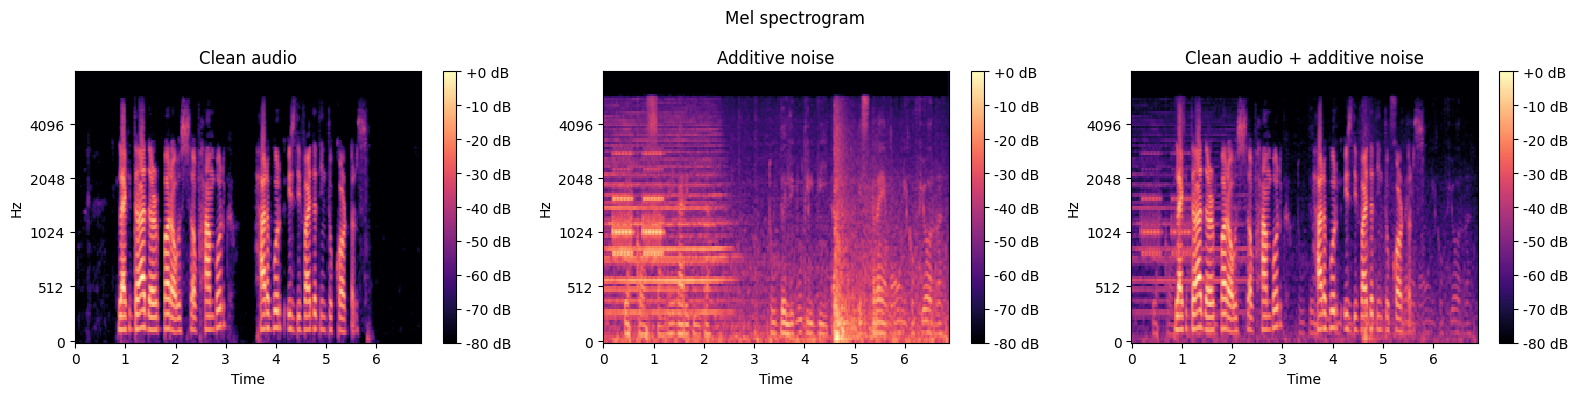

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

S_clean = librosa.feature.melspectrogram(y=audio_signal, sr=SAMPLE_RATE)
img0 = librosa.display.specshow(librosa.power_to_db(S_clean, ref=np.max), x_axis='time', y_axis='mel',
                         sr=SAMPLE_RATE, fmax=8000, ax=ax[0])
ax[0].set_title("Clean audio")
fig.colorbar(img0, ax=ax[0], format='%+2.0f dB')

S_noise = librosa.feature.melspectrogram(y=additive_noise, sr=SAMPLE_RATE)
img1 = librosa.display.specshow(librosa.power_to_db(S_noise, ref=np.max), x_axis='time', y_axis='mel',
                         sr=SAMPLE_RATE, fmax=8000, ax=ax[1])
ax[1].set_title("Additive noise")
fig.colorbar(img1, ax=ax[1], format='%+2.0f dB')

S_aug = librosa.feature.melspectrogram(y=noisy_signal, sr=SAMPLE_RATE)
img2 = librosa.display.specshow(librosa.power_to_db(S_aug, ref=np.max), x_axis='time', y_axis='mel',
                         sr=SAMPLE_RATE, fmax=8000, ax=ax[2])
ax[2].set_title("Clean audio + additive noise")
fig.colorbar(img2, ax=ax[2], format='%+2.0f dB')

plt.suptitle("Mel spectrogram")
plt.tight_layout()
plt.show()

## Plot the amplitude vs time to see the noise effect
- Signal to noise ratio can be seen here more easily

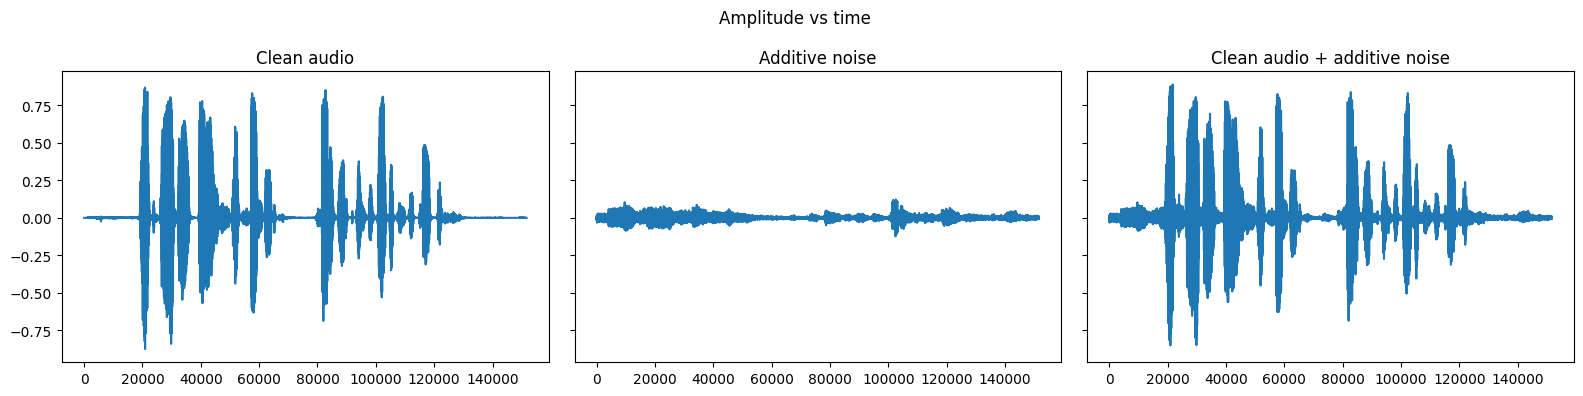

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4), sharey=True)

pd.Series(audio_signal).plot(ax=ax[0])
ax[0].set_title("Clean audio")

pd.Series(additive_noise).plot(ax=ax[1])
ax[1].set_title("Additive noise")

pd.Series(noisy_signal).plot(ax=ax[2])
ax[2].set_title("Clean audio + additive noise")

plt.suptitle("Amplitude vs time")
plt.tight_layout()
plt.show()

In [ ]:
sf.write("clean.wav", audio_signal, SAMPLE_RATE)
sf.write("additive_noise.wav", additive_noise, SAMPLE_RATE)
sf.write("noisy_signal.wav", noisy_signal, SAMPLE_RATE)

In [ ]:
print("Clean audio")
IPython.display.display(IPython.display.Audio("clean.wav"))
print("Additive noise")
IPython.display.display(IPython.display.Audio("additive_noise.wav"))
print("Clean audio + additive noise audio")
IPython.display.display(IPython.display.Audio("noisy_signal.wav"))

Clean audio


Additive noise


Clean audio + additive noise audio


# Samples with different SNR

In [ ]:
def save_and_display_audio(audio_signal, additive_noise, noisy_signal, SNR):
    sf.write(f"./examples/additive_noise_{SNR}.wav", additive_noise, SAMPLE_RATE)
    sf.write(f"./examples/noisy_signal_{SNR}.wav", noisy_signal, SAMPLE_RATE)

    print(f"Signal-to-noise ratio: {SNR}")
    IPython.display.display(IPython.display.Audio(f"./examples/noisy_signal_{SNR}.wav"))

In [ ]:
audio_idx_ex = 2
bg_idx_ex = [6, 7, 8] # range(9)
speech_noise_idx_ex = [0] # range(2)

audio_signal_ex = clean_signals[audio_idx_ex]
noises_ex = [bg_noises[i] for i in bg_idx_ex]  + [speech_noises[i] for i in speech_noise_idx_ex]

processed_noises_ex = process_noises(audio_signal_ex, noises_ex)

In [ ]:
for snr in [0,5,10, 15, 20]:
    noisy_signal_ex, additive_noise_ex = add_background_noise(audio_signal_ex, processed_noises_ex, weights=None, snr_db=snr, verbose=False)
    save_and_display_audio(audio_signal_ex, additive_noise_ex, noisy_signal_ex, snr)

Signal-to-noise ratio: 0


Signal-to-noise ratio: 5


Signal-to-noise ratio: 10


Signal-to-noise ratio: 15


Signal-to-noise ratio: 20


# Make it sound like a telephone

We need:
1. Band-pass filter between ranges 300Hz to 3400Hz
2. Inspired from https://www.nfon.com/en/get-started/cloud-telephony/lexicon/knowledge-base-detail/wideband-audio


In [ ]:
def telephone_filter(signal, sampling_rate, low_cutoff=300, high_cutoff=3400, order=6):
    # Butterworth bandpass filter for low and high cutoff frequency
    b, a = butter(order, [low_cutoff, high_cutoff], btype='bandpass', fs=sampling_rate)
    telephone_signal = lfilter(b, a, signal)

    return telephone_signal

In [ ]:
order = 6
low_cutoff = 300
high_cutoff = 3400

b, a = butter(order, [low_cutoff, high_cutoff], btype='bandpass', fs=SAMPLE_RATE)
telephone_signal = lfilter(b, a, noisy_signal)

w, h = freqz(b, a, fs=SAMPLE_RATE)

## Plot mel-spectrogram and frequencies

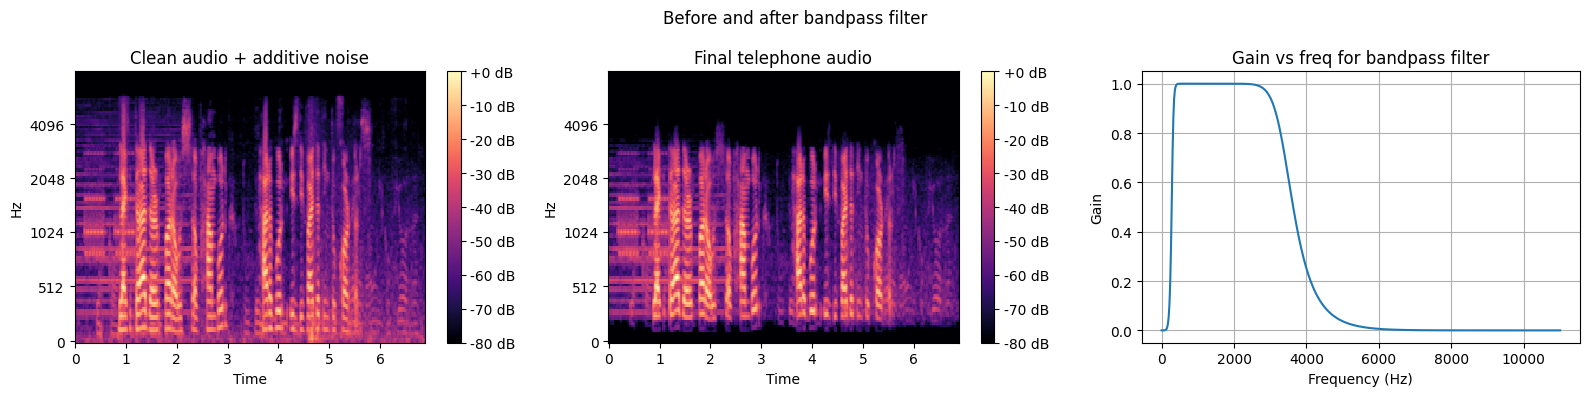

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))

S_aug = librosa.feature.melspectrogram(y=noisy_signal, sr=SAMPLE_RATE)
img0 = librosa.display.specshow(librosa.power_to_db(S_aug, ref=np.max), x_axis='time', y_axis='mel',
                         sr=SAMPLE_RATE, fmax=8000, ax=ax[0])
ax[0].set_title("Clean audio + additive noise")
fig.colorbar(img0, ax=ax[0], format='%+2.0f dB')

S_tel = librosa.feature.melspectrogram(y=telephone_signal, sr=SAMPLE_RATE)
img1 = librosa.display.specshow(librosa.power_to_db(S_tel, ref=np.max), x_axis='time', y_axis='mel',
                         sr=SAMPLE_RATE, fmax=8000, ax=ax[1])
ax[1].set_title("Final telephone audio")
fig.colorbar(img1, ax=ax[1], format='%+2.0f dB')


ax[2].plot(w, abs(h))
ax[2].set_xlabel("Frequency (Hz)")
ax[2].set_ylabel("Gain")
ax[2].grid(True)
ax[2].set_title("Gain vs freq for bandpass filter")

plt.suptitle("Before and after bandpass filter")
plt.tight_layout()
plt.show()

## Plot amplitutde vs time to see the effect

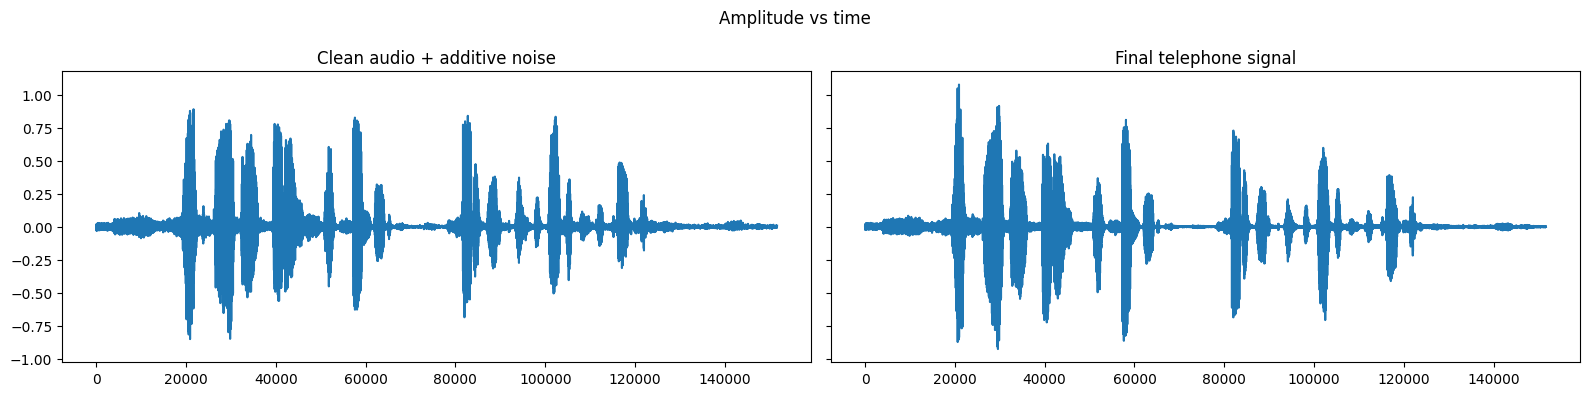

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4), sharey=True, sharex=True)

pd.Series(noisy_signal).plot(ax=ax[0])
ax[0].set_title("Clean audio + additive noise")

pd.Series(telephone_signal).plot(ax=ax[1])
ax[1].set_title("Final telephone signal")

plt.suptitle("Amplitude vs time")
plt.tight_layout()
plt.show()

In [ ]:
sf.write("telephone.wav", telephone_signal, SAMPLE_RATE)

In [ ]:
print("Clean audio + additive noise audio")
IPython.display.display(IPython.display.Audio("noisy_signal.wav"))
print("Telephone audio")
IPython.display.display(IPython.display.Audio("telephone.wav"))

Clean audio + additive noise audio


Telephone audio


# More examples

In [ ]:
def generate_examples(snr = 5):
    for i, audio_idx in enumerate([3, 4]):
        audio_signal = clean_signals[audio_idx]
        sf.write(f"./examples/new_clean_{audio_idx}.wav", audio_signal, SAMPLE_RATE)
        print(f"Clean audio {i}: ")
        IPython.display.display(IPython.display.Audio(f"./examples/new_clean_{audio_idx}.wav"))
        for j, bg_idx in enumerate([[1], [2, 3, 0]]):
            noises = [bg_noises[i] for i in bg_idx]
            processed_noises = process_noises(audio_signal, noises)
            noisy_signal, additive_noise = add_background_noise(audio_signal, processed_noises, weights=None, snr_db=snr, verbose=False)
            telephone_signal = telephone_filter(noisy_signal, SAMPLE_RATE)
            print(f"Augmented {i}{j}: ")
            sf.write(f"./examples/new_telephone_{audio_idx}_{bg_idx}.wav", telephone_signal, SAMPLE_RATE)
            IPython.display.display(IPython.display.Audio(f"./examples/new_telephone_{audio_idx}_{bg_idx}.wav"))

generate_examples()

Clean audio 0: 


Augmented 00: 


Augmented 01: 


Clean audio 1: 


Augmented 10: 


Augmented 11: 
